<a href="https://colab.research.google.com/github/calvinpozderac/Fracton_Thermalization/blob/main/Fracton_Thermalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from IPython.display import clear_output
from datetime import datetime
from scipy.special import binom, comb

In [2]:
# For calculating the size of the symmetry sector
# Returns a 3D array with all values of the symmetry sector for
# 0 <= dipole <= P
# 0 <= charge <= N
# 0 <= system size <= L
def sym_sec(P,N,L):
    vals = [[[0 for i in range(L+1)] for i in range(N+1)] for i in range(P+1)]
    for p in range(P+1):
        for n in range(N+1):
            for l in range(L+1):
                if (p==0) and (n==0):
                    vals[p][n][l] = 1
                elif (p < 0) or (n*(l-1)< p):
                    pass
                elif (p==0) or (n==1):
                    vals[p][n][l] = 1
                else:
                    vals[p][n][l] = vals[p-n][n][l-1] + vals[p][n-1][l]
    return vals

In [3]:
# Finds all strings in the LKS by repeatedly applying U_{3,-} to the fully extended state
# P is assumed to be N(L-1)/2

def LKS_all(N,L):
    #Dipole moment is non integer
    if N%2==1 and L%2 == 0:
        return -1

    #Creates the conjectured fully extended state, s, for the LKS with N and L
    if N<L:
        if L%2==1 and N%2==0:
            s = tuple(0 for i in range((L-1-N)//2))+tuple(1 for i in range(N//2))+tuple([0])+tuple(1 for i in range(N//2))+tuple(0 for i in range((L-1-N)//2))
        elif (L+N)%2==0:
            if N == 1:
                s = tuple(0 for i in range((L-1)//2))+tuple([1])+tuple(0 for i in range((L-1)//2))
            else:
                s = tuple(0 for i in range((L-N-2)//2)) + tuple([1,0])+tuple(1 for i in range(N-2))+tuple([0,1])+tuple(0 for i in range((L-N-2)//2))
    else:
        if (L+N)%2 == 0:
            s = tuple([(N-L+2)//2])+tuple(1 for i in range(L-2))+tuple([(N-L+2)//2])
        else:
            s = tuple([(N-L+3)//2])+tuple(1 for i in range((L-2-1)//2))+tuple([0])+tuple(1 for i in range((L-2-1)//2))+tuple([(N-L+3)//2])
    tot = 1
    done = {s}
    new = [s]
    while len(new)>0:
        for n in nxt(new.pop(),L):
            if n not in done:
                done.add(n)
                new.append(n)
                tot+=1
        prev = new
    return done

# Used in LKS_all
def nxt(prev,L):
    for i in range(1,L-1):
        if prev[i-1]>0 and prev[i+1]>0:
            n = list(prev)
            n[i-1] -= 1
            n[i+1] -= 1
            n[i] += 2
            yield tuple(n)

In [4]:
# Calculates the size of the LKS using the algorithm outlined in App. D
def LKS(N,L):
    s = mins(N,L)
    P = N*(L-1)//2
    fs = [[0 for y in range(L)] for p in range(L)]
    for y in range(0,L):
        fs[y][y] = 1
    y_offset_last = 0
    p_offset_last = 0
    if N == 1:
        y_offset = 0
        p_offset = 0
    for M in range(2,N+1):
        y_offset = int(np.ceil(s[M]/M))
        p_offset = s[M-1]+int(np.ceil(s[M]/M))
        newfs = [[0 for y in range(L-y_offset)] for p in range((L-1)*(M)//2+1-p_offset)]
        for y0 in range(0,L- y_offset):
            y = y0 + y_offset
            for p0 in range(s[M-1]+y - p_offset,min(y+(L-1)*(M-1)//2+1,(L-1)*M//2+1)- p_offset):
                p = p0 + p_offset
                newfs[p0][y0] = sum(fs[p-y-p_offset_last][k-y_offset_last] for k in range(int(np.ceil(s[M-1]/(M-1))),min(y+1,p-y-s[M-2]+1)))
        fs = newfs
        y_offset_last = y_offset*1
        p_offset_last = p_offset*1

    return sum(fs[N*(L-1)//2 - p_offset])


# Calculates the function we call z(N,L,k) as an array to use in LKS()
def mins(N,L):
    if N<L:
        if L%2==1 and N%2==0:
            s = [i for i in range((L-N-1)//2,(L-3)//2+1)]+[i for i in range((L+1)//2,(L+N-1)//2+1)]
        elif (L+N)%2==0:
            if N == 1:
                s = [(L-1)//2]
            elif N == 2:
                s = [(L-2)//2,L//2]
            else:
                s = [(L-N)//2-1]+[i for i in range((L-N)//2+1,(L+N)//2-1)]+[(L+N)//2]
    else:
        if (L+N)%2 == 0:
            s = [0 for i in range((N-L+2)//2)]+[i for i in range(1,L-1)]+[L-1 for i in range((N-L+2)//2)]
        else:
            s = [0 for i in range((N-(L-3))//2)]+[i+1 for i in range((L-3)//2)]+[i+(L+1)//2 for i in range((L-3)//2)]+[L-1 for i in range((N-(L-3))//2)]
    return [sum(s[:n]) for n in range(N+1)]

In [5]:
maxL = 101
maxN = 2*maxL-1
sym = sym_sec(maxN*(maxL-1)//2,maxN,maxL)
Ls = [i for i in range(11,maxL+1,10)]

colors = cm.Blues(np.linspace(0.5, 1, len(Ls)))
all_Ds = []
all_ns = []
for i,L in enumerate(Ls):
    start = time.time()
    Ds = []
    ns = []
    for N in range(L%4+4,2*L,4):
        DLKS = LKS(N,L)
        DS = sym[N*(L-1)//2][N][L]
        Ds.append(DLKS/DS)
        ns.append(N/L)
    all_ns.append(ns)
    all_Ds.append(Ds)
    print("L = {}    Time = {} min".format(L, np.round((time.time()-start)/60,3)))

L = 11    Time = 0.0 min
L = 21    Time = 0.013 min
L = 31    Time = 0.117 min
L = 41    Time = 0.606 min
L = 51    Time = 1.969 min
L = 61    Time = 7.139 min
L = 71    Time = 16.847 min
L = 81    Time = 33.339 min
L = 91    Time = 63.614 min
L = 101    Time = 122.066 min


Text(0, 0.5, 'Percentage in LKS, $D = \\frac{D_{LKS}}{D_{sym}}$')

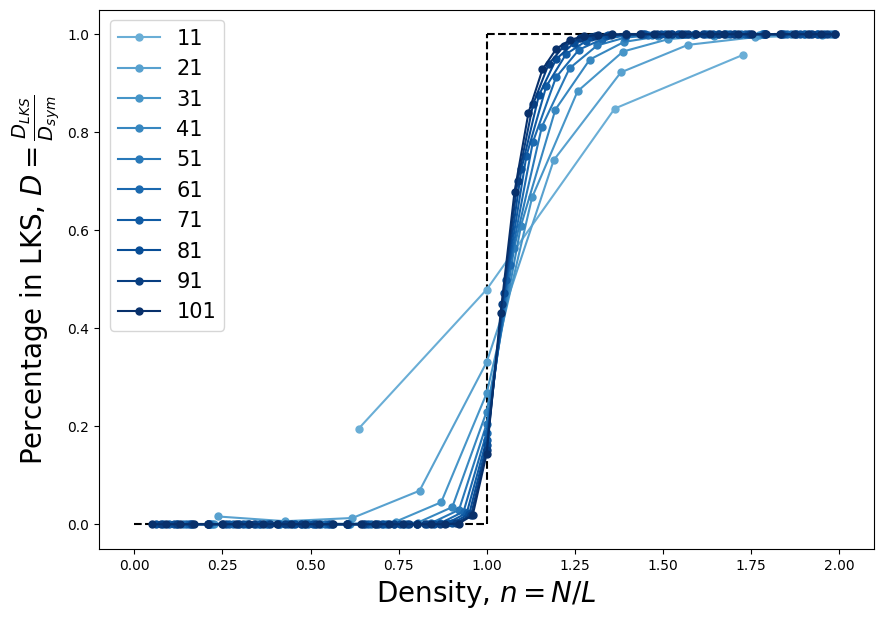

In [6]:
plt.figure(figsize = (10,7))
plt.plot([0,1],[0,0], 'k--')
plt.plot([1,1],[0,1], 'k--')
plt.plot([1,2],[1,1], 'k--')
for i,L in enumerate(Ls):
    plt.plot(all_ns[i],all_Ds[i],'o-', ms = 5,c = colors[i], label = Ls[i])
plt.legend(fontsize = 15)
plt.xlabel(r"Density, $n = N/L$", fontsize = 20)
plt.ylabel(r"Percentage in LKS, $D = \frac{D_{LKS}}{D_{sym}}$", fontsize = 20)